In [1]:
!pip install pydot

In [2]:
import os
import pydot
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_graphviz


In [3]:
DATA_FOLDER = "../data/curated/"
RANDOM_FOREST_SEED = 66
tree_graph_dot_path='../data/curated/rf_data/tree.dot'
tree_graph_png_path='../data/curated/rf_data/tree.png'

# Data Preprocess

In [5]:
# get data
history_data = pd.read_csv(os.path.join(DATA_FOLDER,
                                        "history_data/part-00000-44a6dfb2-eac8-4885-a1f9-702081825d93-c000.csv"))
sa2_info_data = pd.read_csv(os.path.join(DATA_FOLDER,
                                         "sa2_info/part-00000-57c0f807-02d7-4b2e-9d38-aae4903505b5-c000.csv"))
rent_data = pd.read_csv(os.path.join(DATA_FOLDER, "rent.csv"))

parking_spot_sa2 = pd.read_csv(os.path.join(DATA_FOLDER,
                                        "parking_spot_sa2.csv"))
station_sa2 = pd.read_csv(os.path.join(DATA_FOLDER,
                                        "station_sa2.csv"))
tram_stop_sa2 = pd.read_csv(os.path.join(DATA_FOLDER,
                                        "tram_stop_sa2.csv"))

In [6]:
print(history_data.shape)
print(sa2_info_data.shape)
print(rent_data.shape)
print(parking_spot_sa2.shape)
print(station_sa2.shape)
print(tram_stop_sa2.shape)

(522, 5)
(393, 11)
(3748, 10)
(22573, 4)
(219, 4)
(28, 4)


In [7]:
# get ave rent as label
ave_rent_for_sa2 = rent_data.groupby('SA2').agg({'rent':'mean'})

In [8]:
# join feature data
deature_data = history_data.set_index("SA2").join(sa2_info_data.set_index("SA2"), on="SA2", how="inner")
# join label
all_data = deature_data.join(ave_rent_for_sa2, on="SA2", how="inner")

In [9]:
all_data.shape

(298, 15)

In [10]:
all_data

,year,population,bond,price_index,school_count,ERP_population,median_income,metrobus_count,metrotrain_count,metrotram_count,regbus_count,regcoach_count,regtrain_count,skybus_count,rent
SA2,,,,,,,,,,,,,,,
202011018,2021,14951,0.93,185,13,14951,1267,0,0,0,142,2,1,0,525.263158
202011022,2021,21060,0.93,185,9,21060,1238,0,0,0,130,3,1,0,425.833333
203031048,2021,16716,0.93,185,6,16716,1424,0,0,0,74,0,0,0,340.000000
204011062,2021,4142,0.93,185,4,4142,1222,0,0,0,0,10,0,0,595.000000
204021065,2021,4019,0.93,185,4,4019,1344,0,0,0,7,3,0,0,380.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209031209,2021,23711,0.93,185,7,23711,2464,68,1,0,0,0,0,0,458.000000
211011448,2021,15448,0.93,185,4,15448,1960,79,1,0,0,0,0,0,405.000000
213031352,2021,15653,0.93,185,5,15653,2483,86,1,0,0,0,0,0,516.000000


# Feature Selection

In [11]:
# Separate independent and dependent variables
train_Y=np.array(all_data['rent'])
train_X=all_data.drop(['year', 'rent'],axis=1)
train_X_column_name=list(train_X.columns)
train_X=np.array(train_X)


In [12]:
train_X.shape

(298, 13)

In [13]:
# Build RF regression model
random_forest_model=RandomForestRegressor(n_estimators=10,random_state=RANDOM_FOREST_SEED)
random_forest_model.fit(train_X,train_Y)

RandomForestRegressor(n_estimators=10, random_state=66)

In [14]:
# Draw decision tree visualizing plot
random_forest_tree=random_forest_model.estimators_[5]
export_graphviz(random_forest_tree,out_file=tree_graph_dot_path,
                feature_names=train_X_column_name,rounded=True,precision=1)
(random_forest_graph,)=pydot.graph_from_dot_file(tree_graph_dot_path)
random_forest_graph.write_png(tree_graph_png_path)

FileNotFoundError: [Errno 2] "dot" not found in path.

![tree.png](../data/curated/rf_data/tree.png)

Text(0.5, 1.0, 'Variable Importances')

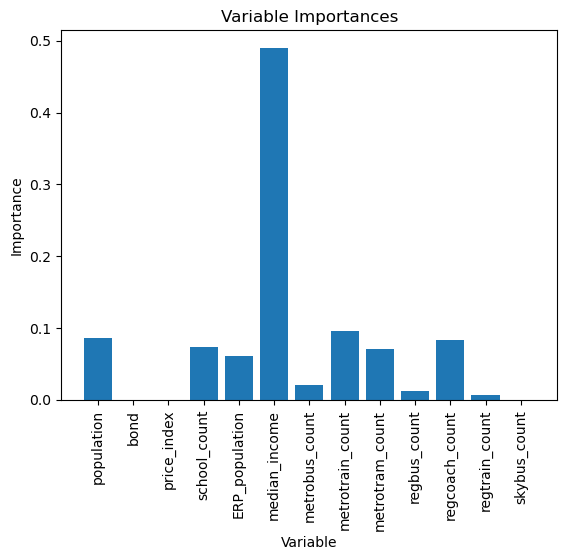

In [13]:
# Calculate the importance of variables

random_forest_importance=list(random_forest_model.feature_importances_)
random_forest_feature_importance=[(feature,round(importance,8)) 
                                  for feature, importance in zip(train_X_column_name,random_forest_importance)]
random_forest_feature_importance=sorted(random_forest_feature_importance,key=lambda x:x[1],reverse=True)
plt.figure(3)
plt.clf()
importance_plot_x_values=list(range(len(random_forest_importance)))
plt.bar(importance_plot_x_values,random_forest_importance,orientation='vertical')
plt.xticks(importance_plot_x_values,train_X_column_name,rotation='vertical')
plt.xlabel('Variable')
plt.ylabel('Importance')
plt.title('Variable Importances')

In [18]:
importance_dict = dict(zip(train_X_column_name, random_forest_importance))

In [24]:
sorted_data = sorted(importance_dict.items(),key=lambda x:x[1],reverse=True)

In [29]:
for fea, var in sorted_data:
    print(f"{fea:<25}{var:.5f}")

median_income            0.49026
metrotrain_count         0.09622
population               0.08590
regcoach_count           0.08333
school_count             0.07346
metrotram_count          0.07099
ERP_population           0.06118
metrobus_count           0.02037
regbus_count             0.01216
regtrain_count           0.00614
skybus_count             0.00000
bond                     0.00000
price_index              0.00000


**In summary, the top 3 importance feature is `median_income, metrotrain_count,population`**